In [47]:
import numpy as np
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
from collections import defaultdict
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import time
import argparse

In [4]:
#upload data
data = pd.read_csv('cheetah.cs.fiu.edu-110108-113008.1.blkparse', header=None)

#split columns
df = pd.DataFrame(data[0].str.split(' ',9).tolist())
#extract one column --> blocktrace sequence
blocktrace = df[3].tolist()
#convert element to int from str
blocktrace = np.array([int(x) for x in blocktrace])

## FIFO

In [5]:
def FIFO(blocktrace, frame):
    cache = np.zeros((frame), dtype=int)
    hit, miss = 0, 0

    #print("block", "\t\t hit", "\t\t miss", "\t\t cache", "\t\tpointer")

    pointer = 0
    for block in tqdm(blocktrace, desc=str(frame), leave=False):
        if block in cache:
            hit += 1

        elif pointer < frame:
            #cache[np.where(cache==0)[0][0]] = block
            cache[pointer] = block
            miss += 1
            pointer += 1

        else:
            cache[pointer % frame] = block
            pointer += 1
            miss += 1

        #print(block, "\t\t", hit, "\t\t", miss, "\t\t", cache, "\t\t", pointer)

    hitrate = hit / (hit + miss)
    #print(hitrate)
    return hitrate

## LFU

In [6]:
def LFU(blocktrace, frame):
    cache = set()
    FU = defaultdict(int)
    FU_cache = defaultdict(int)

    hit, miss = 0, 0
    
    #print("block", "\t\t hit", "\t\t miss", "\t\t cache")
    for block in tqdm(blocktrace, desc="LFU", leave=False):
        FU[block] += 1

        if block in cache:
            hit += 1
            FU_cache[block] = FU[block]
        
        elif len(cache) < frame:
            FU_cache[block] = FU[block]
            cache.add(block)
            miss += 1

        else:
            e, f = min(FU_cache.items(), key=lambda a: a[1])
            FU_cache.pop(e)
            cache.remove(e)
            cache.add(block)
            FU_cache[block] = FU[block]
            miss += 1
        #print(block, "\t\t", hit, "\t\t", miss, "\t\t", cache)

    hitrate = hit / (hit + miss)
    #print("\n\nhitrate: ", hitrate)
    return hitrate

## LRU

In [8]:
def LRU(blocktrace, frame):
    cache = set()
    recent_block = np.array([], dtype=int)
    
    hit, miss = 0, 0
    
    #print("block", "\t\t hit", "\t\t miss", "\t\t cache")
    for block in tqdm(blocktrace, desc="LRU", leave=False):
    
        if block in cache:
            recent_block = np.delete(recent_block, np.argwhere(recent_block==block))
            recent_block = np.append(recent_block, block)
            hit += 1
            
        
        elif len(cache) < frame:
            recent_block = np.append(recent_block, block)
            cache.add(block)
            miss += 1

        else:
            cache.remove(recent_block[0])
            recent_block = recent_block[1:]
            recent_block = np.append(recent_block, block)
            cache.add(block)
            miss += 1
        #print(block, "\t\t", hit, "\t\t", miss, "\t\t", cache)

    hitrate = hit / (hit + miss)
    #print("\n\nhitrate: ", hitrate)
    return hitrate

## OPTIMAL

In [9]:
'''
get the furthest accessed block. Scans OPT dictionary and selects the maximum positioned element
'''

def getFurthestAccessBlock(C, OPT):
    maxAccessPosition = -1
    maxAccessBlock = -1
    for cached_block in C:
        if len(OPT[cached_block]) is 0:
            #print ( "Not Acccessing block anymore " + str(cached_block))
            return cached_block            
    for cached_block in C:  
        if OPT[cached_block][0] > maxAccessPosition:
            maxAccessPosition = OPT[cached_block][0]
            maxAccessBlock = cached_block
    #print ( "chose to evict " + str(maxAccessBlock) + " since its position of access is " + str(maxAccessPosition))
    return maxAccessBlock

In [21]:
def belady_opt(blocktrace, frame):
    OPT = defaultdict(partial(np.ndarray,0))

    for i, block in enumerate(tqdm(blocktrace, desc="OPT: building index")):
        OPT[block] = np.append(OPT[block], i)    

    #print ("created OPT dictionary")    

    hit, miss = 0, 0

    C = set()

    seq_number = 0
    for block in tqdm(blocktrace, desc="OPT", leave=False):

        if block in C:
            #OPT[block] = OPT[block][1:]
            OPT[block] = np.delete(OPT[block],0)
            hit+=1
            #print('hit' + str(block))
            #print(OPT)
        else:
            #print('miss' + str(block))
            miss+=1
            if len(C) == frame:
                fblock = getFurthestAccessBlock(C, OPT)
                assert(fblock != -1)
                C.remove(fblock)
            C.add(block)
            #OPT[block] = OPT[block][1:]
            #print(OPT)
            OPT[block] = np.delete(OPT[block],[0])

    #print ("hit count" + str(hit_count))
    #print ("miss count" + str(miss_count))
    hitrate = hit / (hit + miss)
    #print(hitrate)
    return hitrate

In [11]:
frame_range = [500, 1000, 5000]

In [12]:
#performance = {}

In [13]:
result = []
for frame in frame_range:
    t = time.time()
    ans = LRU(blocktrace, frame)
    result.append((ans, time.time() - t))
performance['LRU'] = result

In [18]:
result = []
for frame in frame_range:
    t = time.time()
    ans = LFU(blocktrace, frame)
    result.append((ans, time.time() - t))
performance['LFU'] = result

In [16]:
result = []
for frame in frame_range:
    t = time.time()
    ans = FIFO(blocktrace, frame)
    result.append((ans, time.time() - t))
performance['FIFO'] = result

In [22]:
result = []
for frame in frame_range:
    t = time.time()
    ans = belady_opt(blocktrace, frame)
    result.append((ans, time.time() - t))
performance['OPT'] = result

In [7]:
LFU([0,1,2,0,1,3,0,3,1,2,1], 3)

0.5454545454545454

In [23]:
performance

{'LRU': [(0.053016501749956535, 9.695297718048096),
  (0.053607631775884616, 9.80590295791626),
  (0.05840999629598833, 12.123212099075317)],
 'FIFO': [(0.05296585505975553, 6.027400493621826),
  (0.05352145681046799, 6.894514083862305),
  (0.05828829305535608, 11.513629674911499)],
 'LFU': [(0.05382609287242326, 81.15716361999512),
  (0.05411561051939315, 175.75272965431213),
  (0.06510896597600707, 715.3645238876343)],
 'OPT': [(0.06331214235499551, 195.38704252243042),
  (0.0713407766329778, 340.75411343574524),
  (0.1217758090241819, 1504.9343848228455)]}

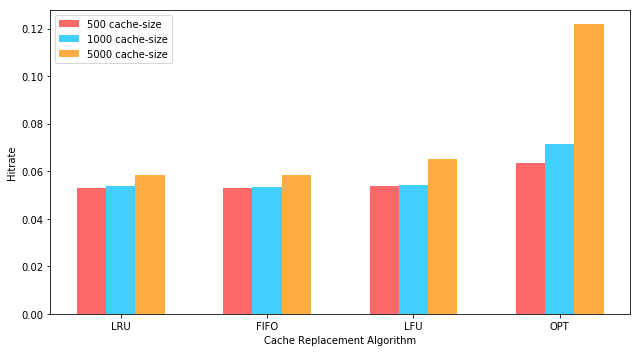

In [62]:
x_index = np.arange(len(performance))

frame_500 = [j[0][0] for i,j in performance.items()]
frame_1000 = [j[1][0] for i,j in performance.items()]
frame_5000 = [j[2][0] for i,j in performance.items()]

fig, ax = plt.subplots()
width = 0.2

bar_500 = ax.bar(x_index, frame_500, width, color='#fd6868', label='500 cache-size')
bar_1000 = ax.bar(x_index + width, frame_1000, width, color='#40cfff', label='1000 cache-size')
bar_5000 = ax.bar(x_index + + width + width, frame_5000, width, color='#ffad40', label='5000 cache-size')



ax.set_xlabel('Cache Replacement Algorithm')
ax.set_ylabel('Hitrate')
#ax.set_title('Project')
ax.set_xticks(x_index + width)
ax.set_xticklabels(('LRU', 'FIFO', 'LFU', 'OPT'))
ax.legend()

fig.set_size_inches(9, 5)
#fig.savefig('test2png.png', dpi=100)
fig.tight_layout()
plt.show()

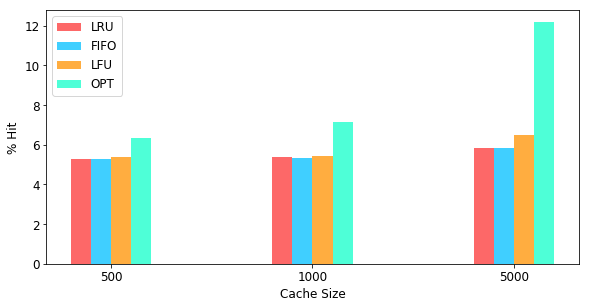

In [86]:
x_index = np.arange(3)

LRU = [i[0]*100 for i in performance['LRU']]
FIFO = [i[0]*100 for i in performance['FIFO']]
LFU = [i[0]*100 for i in performance['LFU']]
OPT = [i[0]*100 for i in performance['OPT']]

fig, ax = plt.subplots()
width = 0.1

bar_LRU = ax.bar(x_index, LRU, width, color='#fd6868', label='LRU')
bar_FIFO = ax.bar(x_index + width, FIFO, width, color='#40cfff', label='FIFO')
bar_LFU = ax.bar(x_index + + width + width, LFU, width, color='#ffad40', label='LFU')
bar_OPT = ax.bar(x_index + + width + width + width, OPT, width, color='#4effd7', label='OPT')

# for i, v in enumerate(LRU):
#     bar_LRU.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

ax.set_xlabel('Cache Size')
ax.set_ylabel('% Hit')
#ax.set_title('Project')
ax.set_xticks(x_index + (3*width) / 2)
ax.set_xticklabels(('500', '1000', '5000'))
ax.legend()
plt.rcParams.update({'font.size': 12})

fig.set_size_inches(9, 5)
fig.savefig('test2png.png', dpi=200)
fig.tight_layout()
plt.show()

In [37]:
frame_1000

[0.053607631775884616,
 0.05352145681046799,
 0.05411561051939315,
 0.0713407766329778]

In [63]:
LRU = [i[0] for i in performance['LRU']]
FIFO = [i[0] for i in performance['FIFO']]
LFU = [i[0] for i in performance['LFU']]
OPT = [i[0] for i in performance['OPT']]


In [64]:
LRU

[0.053016501749956535, 0.053607631775884616, 0.05840999629598833]